###1.Data Setting

In [1]:
#1. 노트북 환경 체크 + 그래프 기본 설정
import sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#1.1 Python/Numpy/Pandas 버전 확인
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("pandas:", pd.__version__)

#1.2 그래프 설정
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid']  = True
plt.rcParams['font.size']  = 11
plt.rcParams['figure.figsize'] = (6,4)

Python: 3.12.12
NumPy: 2.0.2
pandas: 2.2.2


In [2]:
#2. 내부 대류 열전달 계수 h

#2.1 물의 물성치
#물성치(물 20–80°C 근사): 단위 [k: W/m-K, mu: Pa·s, rho: kg/m³, cp: J/kg-K, Pr: -]
WATER = dict(k=0.6, mu=1.0e-3, rho=1000.0, cp=4180.0, Pr=7.0)

#2.2 내부 유동 Nusselt 수 근사, Re < 2300: 완전발달 층류에서 Nu≈3.66 / Re >= 2300: Dittus–Boelter (가열이면 지수 0.4)
def nusselt_internal_pipe(Re, Pr, heating=True):
  if Re < 2300:
      return 3.66
  else: #Re >= 2300
      if heating:
          n = 0.4
      else: #cooling
          n = 0.3
      return 0.023 * (Re**0.8) * (Pr**n)

#2.3 유속 U[m/s], 관내경 D_i[m] → 내부 대류계수 h[W/m^2-K]
def h_inner(U, D_i, fluid=WATER, heating=True):
    Re = fluid["rho"] * U * D_i / fluid["mu"]
    Nu = nusselt_internal_pipe(Re, fluid["Pr"], heating)
    h = Nu * fluid["k"] / D_i
    return h

In [3]:
#3. 고무 링의 온도 분포 T(r)
import numpy as np
import numpy.linalg as la

#3.1 T(r) = C1 ln r + C2 / 경계: -k dT/dr|ri = hi (T(ri)-Ti_inf),  -k dT/dr|ro = ho (T(ro)-To_inf) / 선형 2x2로 C1,C2 결정
def hollow_cylinder_T_profile(ri, ro, hi, Ti_inf, ho, To_inf, k_solid=0.20, Nr_grid=400):
    M = np.array([[hi*np.log(ri) + k_solid/ri, hi],
                  [ho*np.log(ro) + k_solid/ro, ho]], dtype=float)

    rhs = np.array([hi*Ti_inf,ho*To_inf], dtype=float)

    C1, C2 = la.solve(M, rhs)
    r = np.linspace(ri, ro, Nr_grid)
    T = C1 * np.log(r) + C2
    return r, T

In [4]:
#4. 온도 → 물성/열팽창 → 응력(근사) → 라벨

#4.1 온도의존 등가 탄성계수 / 고무 등가 탄성계수: E(T)=E25*exp(-beta*(T-25))  [Pa]
def E_of_T(T_avg, E25=7e6, beta=0.01):
    return E25 * np.exp(-beta * (T_avg - 25.0))

#4.2 열팽창 변형률(분포) / 열팽창 변형률 분포 ε_th(r)≈alpha*(T(r)-T_ref)
def thermal_strain(T_profile, alpha=2.5e-4, T_ref=25.0):
    return alpha * (T_profile - T_ref)

#4.3 매우 단순화된 응력근사 / 평균 팽창 성분은 강체팽창으로 제거
#잔차(gradient)로 인해 생기는 '원주응력 유사' 항을 E/(1-nu) 배로 근사 / 2D에서 von Mises ~ |sigma_θ| 로 보수적으로 본다
def approx_max_von_mises_from_eps_th(eps_th, E, r, nu=0.49):
    eps_mech = -eps_th                  # 외벽 둘레변형≈0을 단순 확장
    sigma_theta = (E/(1.0 - nu)) * eps_mech
    max_vm = np.abs(sigma_theta).max()
    return float(max_vm), sigma_theta

#4.4 한 샘플 라벨 만들기 - h계산 → T(r) → E → ε_th(r) →σ → 라벨
def label_one_sample(U, T_in, T_amb, E25, beta, alpha, h_o,
                     ri=8e-3, ro=10e-3, k_rubber=0.20, D_i=16e-3, sigma_allow=100000): #허용응력 100Pa ~ 0.1MPa
    hi = h_inner(U, D_i=D_i)          # 내부 대류
    r, T = hollow_cylinder_T_profile(ri, ro, hi, T_in, h_o, T_amb, k_solid=k_rubber)
    T_avg = float(T.mean())
    E = E_of_T(T_avg, E25=E25, beta=beta)
    eps_th = thermal_strain(T, alpha=alpha)
    max_vm, sigma_theta = approx_max_von_mises_from_eps_th(eps_th, E,r)
    y_reg = max_vm
    y_cls = int(max_vm <= sigma_allow)  # 허용응력 이내면 1(합격)
    return dict(r=r, T=T, E=E, eps_th=eps_th, sigma_theta=sigma_theta, max_vm=y_reg, pass_flag=y_cls, hi=hi)

,U,T_in,T_amb,E25,beta,alpha,h_o,max_vm,pass
0,1.664374,76.241262,31.068299,8.316885e+06,0.015741,0.000222,16.386909,87640.962190,1
1,1.463327,84.165241,21.159737,7.376384e+06,0.010357,0.000266,7.971450,127022.545896,0
2,1.715159,77.580601,33.824379,5.979419e+06,0.017778,0.000277,19.229336,71951.215675,1
3,1.618421,78.046534,26.269865,7.982700e+06,0.008615,0.000217,8.910721,116418.854721,0
4,1.256506,87.645656,12.897472,5.337924e+06,0.013076,0.000204,6.523958,61162.438031,1


                 U         T_in        T_amb           E25         beta  \
count  1000.000000  1000.000000  1000.000000  1.000000e+03  1000.000000   
mean      1.498307    85.169912    22.321836  6.974289e+06     0.012289   
std       0.174951     5.786853     7.239286  1.161105e+06     0.004228   
min       1.200740    75.010375    10.024750  5.002569e+06     0.005014   
25%       1.344156    79.990122    16.118264  5.990773e+06     0.008635   
50%       1.496894    84.930080    22.386112  6.977951e+06     0.012186   
75%       1.655336    90.261067    28.647973  7.981519e+06     0.015891   
max       1.799463    94.988438    34.994133  8.997636e+06     0.019996   

             alpha          h_o         max_vm  
count  1000.000000  1000.000000    1000.000000  
mean      0.000249    17.399035  106743.194660  
std       0.000029     7.118055   33665.607120  
min       0.000200     5.010423   43557.728417  
25%       0.000224    11.326760   82638.280911  
50%       0.000249    17.41524

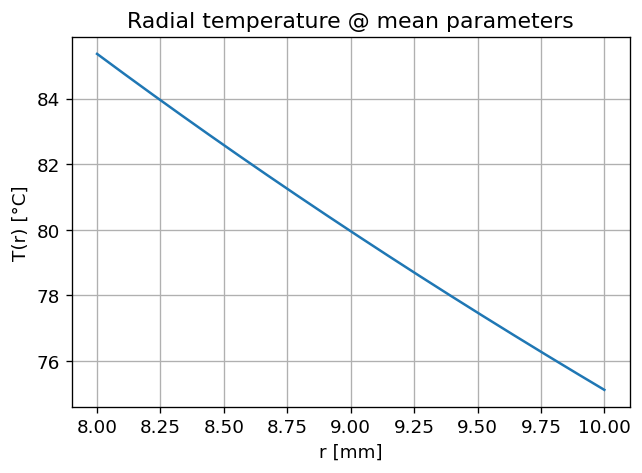

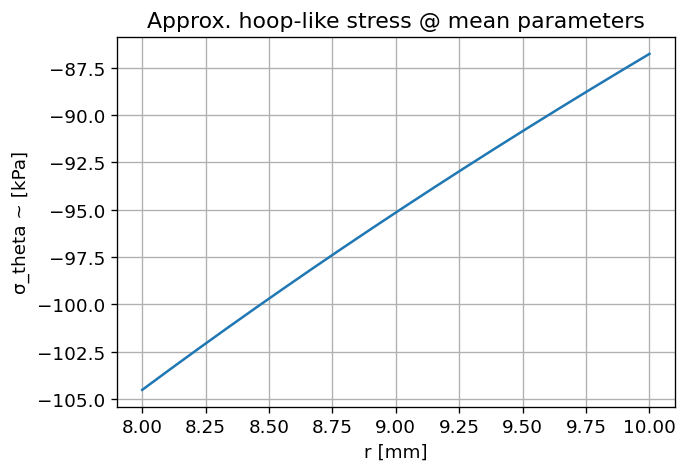

=== Mean parameters ===
     U: 1.49831
  T_in: 85.1699
 T_amb: 22.3218
   E25: 6.97429e+06
  beta: 0.0122891
 alpha: 0.000249041
   h_o: 17.399

approx max von Mises ~ 104.51 kPa,  h_i=5992 W/m²K,  dataset pass rate=46.40%


In [5]:
#5. 랜덤 데이터셋 생성 + 빠른 확인용 플롯
from numpy.random import default_rng
rng = default_rng(42)

#5.1 무작위로 생성한 열·유동·재료 파라미터에 해석 라벨(max_vm, pass)을 붙여 CSV로 저장, 요약 통계를 보여주는 데이터셋 생성 함수
def make_dataset_csv(N=1000, out_csv="dataset.csv"):
    U     = rng.uniform(1.2, 1.8, N)        # m/s
    T_in  = rng.uniform(75, 95, N)          # ℃
    T_amb = rng.uniform(10, 35, N)          # ℃
    E25   = rng.uniform(5e6, 9e6, N)        # Pa
    beta  = rng.uniform(0.005, 0.02, N)     # 1/℃
    alpha = rng.uniform(2.0e-4, 3.0e-4, N)  # 1/℃
    h_o   = rng.uniform(5, 30, N)           # 외부 대류 [W/m^2-K]

    rows = []
    for i in range(N):
        lab = label_one_sample(U[i],T_in[i],T_amb[i],E25[i],beta[i],alpha[i],h_o[i])
        rows.append([U[i],T_in[i],T_amb[i],E25[i],beta[i],alpha[i],h_o[i], lab["max_vm"], lab["pass_flag"]])
    df = pd.DataFrame(rows, columns=["U","T_in","T_amb","E25","beta","alpha","h_o","max_vm","pass"])
    df.to_csv(out_csv, index=False)
    return df

df = make_dataset_csv(N=1000)
display(df.head())
print(df.describe()[["U","T_in","T_amb","E25","beta","alpha","h_o","max_vm"]])


# 5.2 평균 파라미터로 온도/응력 분포 보기
# 주의: 개별 프로파일들의 평균이 아니라, "평균 파라미터"에서 계산한 단일 프로파일
mu = df[["U","T_in","T_amb","E25","beta","alpha","h_o"]].mean()

avg = label_one_sample(
    U=float(mu["U"]),
    T_in=float(mu["T_in"]),
    T_amb=float(mu["T_amb"]),
    E25=float(mu["E25"]),
    beta=float(mu["beta"]),
    alpha=float(mu["alpha"]),
    h_o=float(mu["h_o"]))

r_mm = avg["r"] * 1e3

fig, ax = plt.subplots()
ax.plot(r_mm, avg["T"])
ax.set_xlabel("r [mm]")
ax.set_ylabel("T(r) [°C]")
ax.set_title("Radial temperature @ mean parameters")
plt.show()

fig, ax = plt.subplots()
ax.plot(r_mm, avg["sigma_theta"] / 1e3) #kpa
ax.set_xlabel("r [mm]")
ax.set_ylabel("σ_theta ~ [kPa]")
ax.set_title("Approx. hoop-like stress @ mean parameters")
plt.show()

pass_rate = float(df["pass"].mean())  # bool이면 True 비율로 계산됨
print("=== Mean parameters ===")
for k in ["U","T_in","T_amb","E25","beta","alpha","h_o"]:
    print(f"{k:>6}: {mu[k]:.6g}")
print(f"\napprox max von Mises ~ {avg['max_vm']/1e3:.2f} kPa,  "
      f"h_i={avg['hi']:.0f} W/m²K,  "
      f"dataset pass rate={pass_rate:.2%}")

###2.Machine Learning

In [6]:
# 6. CSV → 라벨 점검/백업 → 학습/테스트 분할 → 스케일러 저장
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 6.1 데이터/타깃 정의
df = pd.read_csv("dataset.csv")
X_cols = ['U','T_in','T_amb','E25','beta','alpha','h_o']
y_reg  = 'max_vm'
y_cls  = 'pass'  # 기본 라벨(없거나 심하게 불균형이면 아래에서 보조 라벨 생성)

# 6.2 라벨 검진 → 필요 시 보조 라벨(pass_median) 생성(훈련-유사 중앙값 기반)
use_backup = False
if (y_cls not in df.columns) or (df[y_cls].nunique() < 2) or (df[y_cls].value_counts().min() < 20):
    # 잠정 분할(비층화)로 "훈련 중앙값" 구해 라벨 정의 → 이후 최종 분할은 층화로 다시 수행
    idx = np.arange(len(df))
    idx_tr, _ = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)
    thr = float(np.median(df.loc[idx_tr, y_reg].values))
    df['pass_median'] = (df[y_reg] <= thr).astype(int)
    y_cls = 'pass_median'
    use_backup = True

 # 6.3 최종 입력/타깃 & 층화 분할
X   = df[X_cols].values
y_r = df[y_reg].values
y_c = df[y_cls].values

X_train, X_test, y_r_train, y_r_test, y_c_train, y_c_test = train_test_split(
    X, y_r, y_c, test_size=0.2, random_state=42, stratify=y_c)

print("Train/Test:", X_train.shape, X_test.shape,
      "| class counts:", f"[0: {np.bincount(y_c)[0]}, 1: {np.bincount(y_c)[1]}]")

# 6.4 REG(전역) 정리 저장 + 스케일러
REG = {
    "X_cols": X_cols, "y_reg_name": y_reg, "y_cls_name": y_cls,
    "X_train": X_train, "X_test": X_test,
    "y_r_train": y_r_train, "y_r_test": y_r_test,
    "y_c_train": y_c_train, "y_c_test": y_c_test,
    "used_backup_cls": use_backup}

x_scaler = StandardScaler().fit(X_train)  # 이후 MLP/시나리오 공용
REG["x_scaler"] = x_scaler

Train/Test: (800, 7) (200, 7) | class counts: [0: 536, 1: 464]


In [8]:
# 7. 회귀 베이스라인들을 한 번에 학습·평가 (상세 로그판)
# (표준화+모델 파이프라인, GridSearchCV로 탐색, RMSE/R² 계산)
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# 7.1 교차검증 설정 (KFold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 7.2 모델 파이프라인·그리드 정의
models = {
    # 7.2.1 Linear 파이프라인
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),

    # 7.2.2 Ridge 그리드서치
    "RidgeGS": GridSearchCV(
        make_pipeline(StandardScaler(), Ridge()),
        param_grid={"ridge__alpha":[0.01, 0.1, 1, 10, 100]},
        cv=cv, n_jobs=-1),

    # 7.2.3 RandomForest 그리드서치
    "RF-GS": GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid={"n_estimators":[200,400], "max_depth":[None,8,12], "min_samples_leaf":[1,3]},
        cv=cv, n_jobs=-1)}

# 7.3 학습·예측 루프 및 지표 계산 (RMSE, R², best params)
rows = []
Xtr, Xte = REG["X_train"], REG["X_test"]
yr_tr, yr_te = REG["y_r_train"], REG["y_r_test"]

for name, mdl in models.items():
    mdl.fit(Xtr, yr_tr)
    pred = mdl.predict(Xte)
    mse  = mean_squared_error(yr_te, pred)   # 구버전 호환: squared 인자 미사용
    rmse = float(mse ** 0.5)
    r2   = r2_score(yr_te, pred)
    best = getattr(mdl, "best_params_", None)
    rows.append([name, rmse, r2, best])

reg_results = pd.DataFrame(rows, columns=["model","rmse","r2","best_params"])

for _, r in reg_results.sort_values("rmse").iterrows():
    print(f"{r['model']:<12s}  RMSE={r['rmse']:10.4f}  R2={r['r2']:.4f}  best={r['best_params']}")

# 7.4 베이스라인 최고 회귀기 확정 & REG 등록 (모델·RMSE 기록)
best_name = reg_results.sort_values("rmse", ascending=True).iloc[0]["model"]
best_reg  = models[best_name]
if hasattr(best_reg, "best_estimator_"):
    best_reg = best_reg.best_estimator_

REG["best_reg_baseline"] = best_reg
REG["baseline_rmse"]     = float(reg_results.loc[reg_results["model"]==best_name, "rmse"].values[0])
REG["reg_results"]       = reg_results.copy()  # 나중(9번/리포트) 재사용
REG["baseline_models_dict"] = models
print(f"\n[REG] best baseline = {best_name} | RMSE={REG['baseline_rmse']:.4f}")

RF-GS         RMSE= 5848.0175  R2=0.9686  best={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
Linear        RMSE= 7019.0830  R2=0.9548  best=None
RidgeGS       RMSE= 7020.3912  R2=0.9548  best={'ridge__alpha': 1}

[REG] best baseline = RF-GS | RMSE=5848.0175


In [9]:
# 8. 분류(pass/fail) 베이스라인들을 한 번에 학습·튜닝·평가 + 임계값 정책(τ*) 확정
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
import numpy as np
import pandas as pd

# 8.1 임계값 기준 설정
POLICY = "recall_at"   # "max_f1" 또는 "recall_at"
TARGET_REC = 0.98      # POLICY="recall_at"일 때 목표 재현율

# 8.2 분류 모델 파이프라인/그리드 정의
clf_models = {
    "LogReg": GridSearchCV(
        make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, solver="lbfgs")),
        param_grid={
            "logisticregression__C":[0.1, 1, 5, 10],
            "logisticregression__class_weight":[None, "balanced"]
        },
        cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1),

    "DT": GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid={
            "max_depth":[None, 4, 6, 10],
            "min_samples_leaf":[1, 3, 5],
            "class_weight":[None, "balanced"]
        },
        cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1),

    "RF": GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid={
            "n_estimators":[200, 400],
            "max_depth":[None, 8, 12],
            "min_samples_leaf":[1, 3],
            "class_weight":[None, "balanced"]
        },
        cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)}

def _proba(mdl, X):
    #GridSearchCV/파이프라인 포함 대응: 클래스1 확률 벡터 반환.
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:, 1]
    m = mdl.decision_function(X)  # 없으면 예외 → 상위에서 처리
    return 1.0 / (1.0 + np.exp(-m))

# 8.3 학습·튜닝·평가 루프 (ACC/F1/AUC 로깅)
rows = []
for name, mdl in clf_models.items():
    mdl.fit(REG["X_train"], REG["y_c_train"])
    ypred = mdl.predict(REG["X_test"])
    try:
        p = _proba(mdl, REG["X_test"])
        auc = roc_auc_score(REG["y_c_test"], p)
    except Exception:
        p, auc = None, np.nan

    acc = accuracy_score(REG["y_c_test"], ypred)
    f1  = f1_score(REG["y_c_test"], ypred)
    rows.append([name, acc, f1, auc, getattr(mdl, "best_params_", None)])

clf_results = pd.DataFrame(rows, columns=["model","acc","f1","auc","best_params"])
print("\n[Classifier baselines]")

for _, r in clf_results.sort_values(["f1","auc"], ascending=[False, False]).iterrows():
    print(f"{r['model']:<8s}  ACC={r['acc']:.3f}  F1={r['f1']:.3f}  AUC={r['auc']:.3f}  best={r['best_params']}")

REG["clf_results"] = clf_results.copy()

# 8.4 최고 모델 혼동행렬 + 리포트 (F1→AUC 우선)
best_name = clf_results.sort_values(["f1","auc"], ascending=[False, False]).iloc[0]["model"]
best_mdl  = clf_models[best_name]
ypred     = best_mdl.predict(REG["X_test"])
cm        = confusion_matrix(REG["y_c_test"], ypred)
tn, fp, fn, tp = cm.ravel()

print(f"\nBest classifier: {best_name}")
print(cm)
print("\n[Confusion matrix interpretation]")
print(f"- 실제 0(불합격) {tn+fp}개 중 {tn}개 맞춤, {fp}개를 합격으로 잘못 판단")
print(f"- 실제 1(합격)   {tp+fn}개 중 {tp}개 맞춤, {fn}개를 불합격으로 잘못 판단")
print(classification_report(REG["y_c_test"], ypred, digits=3))

# 8.5 최고 분류기 확정 & PR-커브 기반 임계값 τ 산정·REG 등록
p_test = _proba(best_mdl, REG["X_test"])
prec, rec, thr = precision_recall_curve(REG["y_c_test"], p_test)  # len(thr)=len(prec)-1=len(rec)-1
f1s = 2 * prec * rec / (prec + rec + 1e-12)

def _tau_max_f1():
    if len(thr) == 0: return 0.5
    return float(thr[np.argmax(f1s[:-1])])  # thr 길이와 정합

def _tau_recall_at(target=TARGET_REC):
    if len(thr) == 0: return _tau_max_f1()
    mask = (rec[:-1] >= float(target))     # thr 길이와 정합
    if np.any(mask):
        f1_cut  = f1s[:-1][mask]
        thr_cut = thr[mask]
        return float(thr_cut[np.argmax(f1_cut)])
    return _tau_max_f1()  # 목표 재현율 구간이 없으면 F1 최대값으로 폴백

if POLICY == "recall_at":
    tau_star   = _tau_recall_at(TARGET_REC)
    tau_policy = f"recall≥{TARGET_REC:.2f}"
else:
    tau_star   = _tau_max_f1()
    tau_policy = "max_f1"

REG["best_clf"]   = best_mdl
REG["tau_star"]   = float(tau_star)
REG["tau_policy"] = tau_policy
print(f"[REG] best classifier = {best_name}, tau* = {REG['tau_star']:.3f} (policy={REG['tau_policy']})")


[Classifier baselines]
LogReg    ACC=0.965  F1=0.961  AUC=0.994  best={'logisticregression__C': 1, 'logisticregression__class_weight': None}
RF        ACC=0.940  F1=0.935  AUC=0.991  best={'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
DT        ACC=0.885  F1=0.877  AUC=0.937  best={'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 5}

Best classifier: LogReg
[[106   1]
 [  6  87]]

[Confusion matrix interpretation]
- 실제 0(불합격) 107개 중 106개 맞춤, 1개를 합격으로 잘못 판단
- 실제 1(합격)   93개 중 87개 맞춤, 6개를 불합격으로 잘못 판단
              precision    recall  f1-score   support

           0      0.946     0.991     0.968       107
           1      0.989     0.935     0.961        93

    accuracy                          0.965       200
   macro avg      0.968     0.963     0.965       200
weighted avg      0.966     0.965     0.965       200

[REG] best classifier = LogReg, tau* = 0.107 (policy=recall≥0.98)


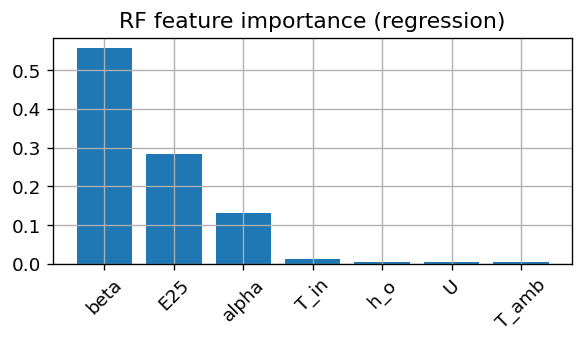

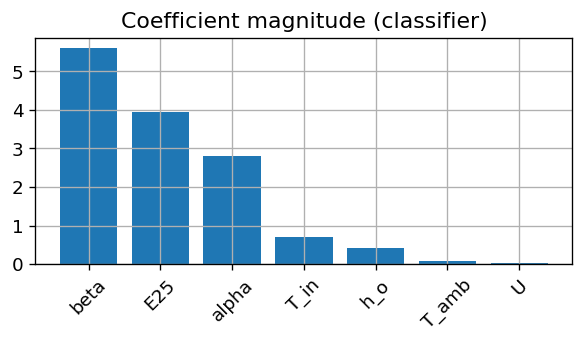

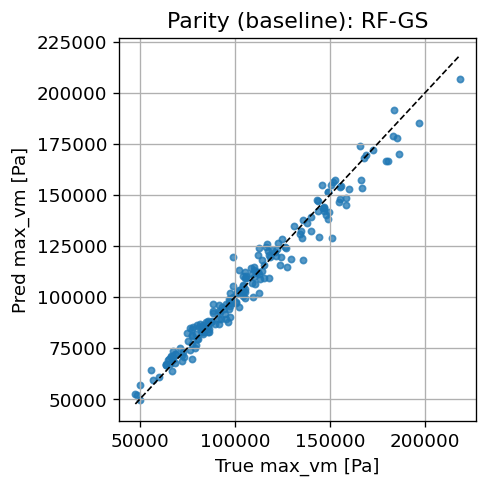

In [10]:
# 9. RF 중요도(회귀/분류) + 베이스라인 Parity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# 9.1 REG 데이터 준비
X_cols      = REG["X_cols"]
X_test      = REG["X_test"]
y_r_test    = REG["y_r_test"]
models      = REG["baseline_models_dict"]   # 7번에서 저장
reg_results = REG["reg_results"]            # 7번 결과표
best_clf    = REG["best_clf"]               # 8번 최고 분류기

def _plot_bar(importances, feature_names, title): # 공통 막대 플로터 함수
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(5,3))
    plt.bar(range(len(feature_names)), importances[idx])
    plt.xticks(range(len(feature_names)), np.array(feature_names)[idx], rotation=45)
    plt.title(title)
    plt.tight_layout(); plt.show()

# 9.2 RF(회귀) 중요도 — 7번의 "RF-GS"
rf_reg = models["RF-GS"]
rf_reg_est = rf_reg.best_estimator_ if hasattr(rf_reg, "best_estimator_") else rf_reg
_plot_bar(rf_reg_est.feature_importances_, X_cols, "RF feature importance (regression)")

# 9.3 분류 최고모델 중요도 — 파이프라인/그리드서치 대응 (feature_importances_ 또는 coef_)
clf_est  = best_clf.best_estimator_ if hasattr(best_clf, "best_estimator_") else best_clf
final_est = clf_est.steps[-1][1] if isinstance(clf_est, Pipeline) else clf_est

if hasattr(final_est, "feature_importances_"):
    _plot_bar(final_est.feature_importances_, X_cols, "Feature importance (classifier)")
elif hasattr(final_est, "coef_"):
    coef = np.abs(np.atleast_2d(final_est.coef_)).mean(axis=0)   # 멀티클래스 대비 평균 절댓값
    _plot_bar(coef, X_cols, "Coefficient magnitude (classifier)")
else:
    print("[9] classifier has no importances/coef_. skip bar plot.")

# 9.4 베이스라인 Parity plot — 7번 결과표 기준 최우수 모델
best_name = reg_results.sort_values("rmse", ascending=True).iloc[0]["model"]
best_reg  = models[best_name]
if hasattr(best_reg, "best_estimator_"):
    best_reg = best_reg.best_estimator_

yhat = best_reg.predict(X_test)
lims = [min(y_r_test.min(), yhat.min()), max(y_r_test.max(), yhat.max())]

plt.figure(figsize=(4.2,4.2))
plt.scatter(y_r_test, yhat, s=14, alpha=0.75)
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True max_vm [Pa]")
plt.ylabel("Pred max_vm [Pa]")
plt.title(f"Parity (baseline): {best_name}")
plt.tight_layout(); plt.show()

###3.PyTorch Surrogate Training

  50  train_MSE=1.1983e-01  val_MSE=1.2710e-01
 100  train_MSE=5.0820e-02  val_MSE=5.7988e-02
 150  train_MSE=2.4024e-02  val_MSE=3.0194e-02
 200  train_MSE=1.3620e-02  val_MSE=1.8976e-02
 250  train_MSE=9.3298e-03  val_MSE=1.4128e-02
 300  train_MSE=7.3528e-03  val_MSE=1.1799e-02
 350  train_MSE=6.1821e-03  val_MSE=1.0376e-02
 400  train_MSE=5.4219e-03  val_MSE=9.4040e-03
 450  train_MSE=4.8532e-03  val_MSE=8.6197e-03
 500  train_MSE=4.4020e-03  val_MSE=8.0128e-03
 550  train_MSE=4.0130e-03  val_MSE=7.5162e-03
 600  train_MSE=3.7048e-03  val_MSE=7.0868e-03
MLP Test RMSE = 2.7282e+04 Pa


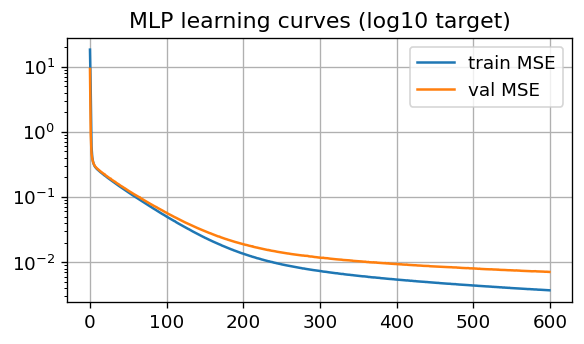

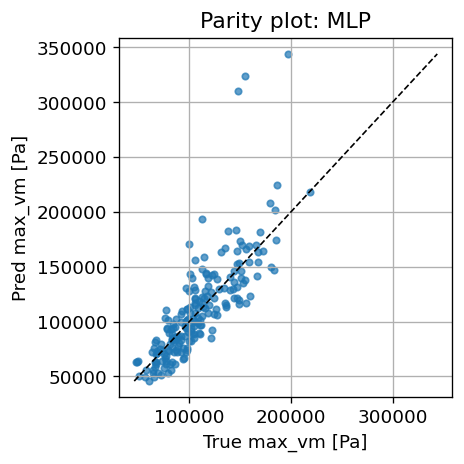

[REG] final regressor = Baseline (baseline_rmse=5.8480e+03, mlp_rmse=2.7282e+04)


In [12]:
# 10. 수동 SGD로 MLP 학습/평가 (간결판) — torch.optim 미사용
import numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 10.1 시드설정
np.random.seed(0); torch.manual_seed(0)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(0)

# 10.2 스케일링 + log10 타깃
x_scaler = REG["x_scaler"]
Xtr = x_scaler.transform(REG["X_train"]).astype(np.float32)
Xte = x_scaler.transform(REG["X_test"] ).astype(np.float32)
ytr = np.log10(np.clip(REG["y_r_train"], 1e-12, None)).astype(np.float32).reshape(-1,1)
yte = np.log10(np.clip(REG["y_r_test"],  1e-12, None)).astype(np.float32).reshape(-1,1)

tr_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr)),
    batch_size=64, shuffle=True)

te_dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(Xte), torch.from_numpy(yte)),
    batch_size=256, shuffle=False)

# 10.3 모델
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=128, d_out=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.ReLU(),
            nn.Linear(d_hidden, d_hidden), nn.ReLU(),
            nn.Linear(d_hidden, d_out))
    def forward(self, x): return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = MLP(d_in=Xtr.shape[1]).to(device)
lossf  = nn.MSELoss()

# 10.4 하이퍼파라미터
lr, weight_decay = 3e-3, 1e-4
epochs, patience = 600, 80
best_state, best_val, bad = None, float('inf'), 0
train_hist, val_hist = [], []

# 10.5 학습 루프 (수동 SGD + L2)
for ep in range(epochs):
    model.train()
    tr_sum, n_tr = 0.0, 0
    for xb, yb in tr_dl:
        xb, yb = xb.to(device), yb.to(device)
        # fwd
        pred = model(xb)
        loss = lossf(pred, yb)
        # bwd
        for p in model.parameters():
            if p.grad is not None:
                p.grad.detach_(); p.grad.zero_()
        loss.backward()
        # step (SGD + L2)
        with torch.no_grad():
            for p in model.parameters():
                if p.grad is None: continue
                p.grad.add_(weight_decay * p)   # L2
                p.add_(-lr * p.grad)
        tr_sum += float(loss.item()) * len(xb); n_tr += len(xb)
    train_hist.append(tr_sum / max(n_tr,1))

    # 검증 (로그공간 MSE)
    model.eval()
    with torch.no_grad():
        yp, yt = [], []
        for xb, yb in te_dl:
            yp.append(model(xb.to(device)).cpu().numpy())
            yt.append(yb.numpy())
        yp = np.vstack(yp).ravel(); yt = np.vstack(yt).ravel()
        val_mse = mean_squared_error(yt, yp)
    val_hist.append(val_mse)

    # early stopping
    improved = val_mse < best_val - 1e-8
    if improved:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
    if (ep+1) % 50 == 0:
        print(f"{ep+1:4d}  train_MSE={train_hist[-1]:.4e}  val_MSE={val_mse:.4e}")
    if bad >= patience:
        print(f"Early stop at epoch {ep+1}")
        break

# 10.6 베스트 복원 & 테스트 RMSE(원공간 Pa)
if best_state is not None: model.load_state_dict(best_state)
model.eval()
with torch.no_grad():
    yhat_log = model(torch.from_numpy(Xte).to(device)).cpu().numpy().ravel()
yhat = 10.0**yhat_log
rmse = float(mean_squared_error(REG["y_r_test"], yhat) ** 0.5)
print(f"MLP Test RMSE = {rmse:.4e} Pa")

# 10.7 학습곡선/정합 플롯
plt.figure(figsize=(5,3))
plt.plot(train_hist, label='train MSE'); plt.plot(val_hist, label='val MSE')
plt.yscale('log'); plt.legend(); plt.title("MLP learning curves (log10 target)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4))
y_true = REG["y_r_test"]
lims = [min(y_true.min(), yhat.min()), max(y_true.max(), yhat.max())]
plt.scatter(y_true, yhat, s=15, alpha=0.7)
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True max_vm [Pa]"); plt.ylabel("Pred max_vm [Pa]")
plt.title("Parity plot: MLP"); plt.tight_layout(); plt.show()

# 10.8 REG 등록 (MLP vs 베이스라인 비교)
baseline_rmse = REG.get("baseline_rmse", float("inf"))
use_mlp  = rmse < baseline_rmse
REG["best_reg"]   = model if use_mlp else REG["best_reg_baseline"]
REG["inv_target"] = "log10" if use_mlp else None
REG["mlp_model"]  = model
REG["mlp_rmse"]   = rmse

print(f"[REG] final regressor = {'MLP' if use_mlp else 'Baseline'} "
      f"(baseline_rmse={baseline_rmse:.4e}, mlp_rmse={rmse:.4e})")

###4.Sensitivity Analysis

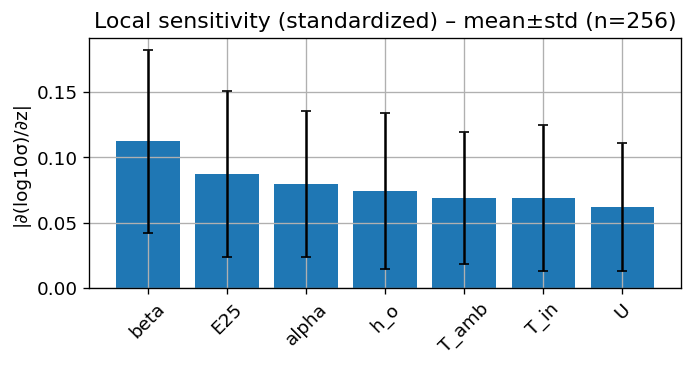

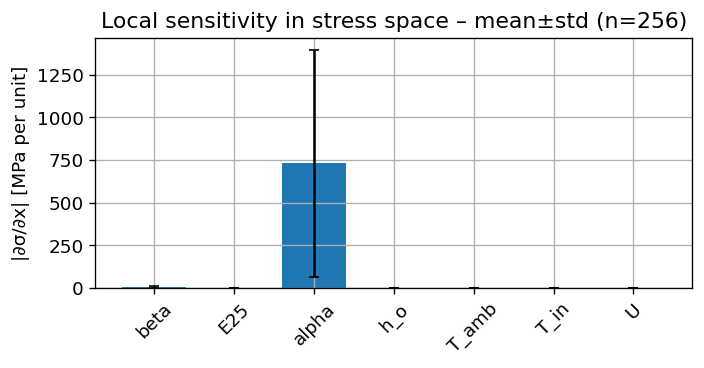

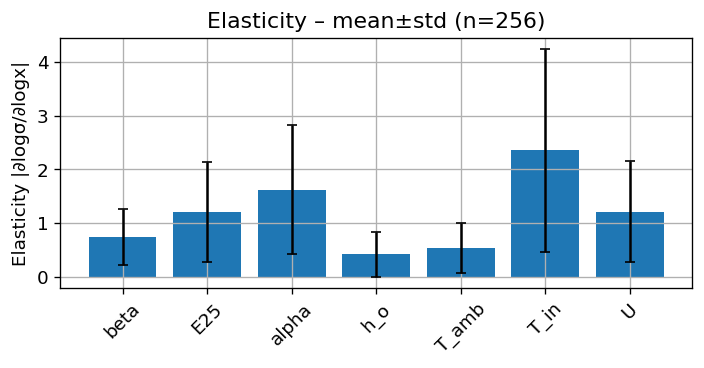

In [13]:
# 11. MLP 민감도(∂y/∂x, y=log10σ) & 탄력도 시각화 — 간결판
import numpy as np, torch, matplotlib.pyplot as plt

#11.1 데이터 설정
model    = REG["mlp_model"]; model.eval()
x_scaler = REG["x_scaler"]
X_cols   = REG["X_cols"]
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#11.2 표준화 입력에서 샘플 선택
Xtr_std = x_scaler.transform(REG["X_train"]).astype(np.float32)
n_pick  = min(256, len(Xtr_std))
idx     = np.random.choice(len(Xtr_std), size=n_pick, replace=False)
xb      = torch.from_numpy(Xtr_std[idx]).to(device).requires_grad_(True)

#11.3 y = log10(σ), 입력 기울기 d(log10σ)/dz
y     = model(xb)    # (n,1)
grads = torch.autograd.grad(y, xb, grad_outputs=torch.ones_like(y))[0].cpu().numpy()  # (n,d)

#11.4 표준화 좌표 기준 민감도
Az = np.abs(grads)
m_z, s_z = Az.mean(axis=0), Az.std(axis=0)

#11.5 원단위로 환산: d(log10σ)/dx = d(log10σ)/dz / std(x)
eps  = 1e-12
A_x  = Az / (x_scaler.scale_[None, :] + eps)
m_x, s_x = A_x.mean(axis=0), A_x.std(axis=0)

#11.6 응력 단위(Pa/unit): dσ/dx = (ln10)*σ*d(log10σ)/dx
sigma = (10.0 ** y.detach().cpu().numpy().ravel()).astype(np.float64)
dSigma = (np.log(10.0) * sigma[:, None]) * (grads / (x_scaler.scale_[None, :] + eps))
A_s    = np.abs(dSigma)
m_s, s_s = A_s.mean(axis=0), A_s.std(axis=0)

#11.7 탄력도: |∂logσ/∂logx| = | (x/σ) * (∂σ/∂x) |
x_batch = x_scaler.inverse_transform(Xtr_std[idx])     # (n,d) 원단위
Elas    = np.abs((x_batch / (sigma[:, None] + eps)) * dSigma)
m_e, s_e = Elas.mean(axis=0), Elas.std(axis=0)

#11.8 중요도 큰 순으로 정렬(표준화 민감도 기준)
order  = np.argsort(-m_z)
labels = np.array(X_cols)[order]

#11.9 플롯 3종
plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), m_z[order], yerr=s_z[order], capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('|∂(log10σ)/∂z|')
plt.title(f'Local sensitivity (standardized) – mean±std (n={n_pick})')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), (m_s[order]/1e6), yerr=(s_s[order]/1e6), capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('|∂σ/∂x| [MPa per unit]')
plt.title(f'Local sensitivity in stress space – mean±std (n={n_pick})')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.2))
plt.bar(range(len(X_cols)), m_e[order], yerr=s_e[order], capsize=3)
plt.xticks(range(len(X_cols)), labels, rotation=45)
plt.ylabel('Elasticity |∂logσ/∂logx|')
plt.title(f'Elasticity – mean±std (n={n_pick})')
plt.tight_layout(); plt.show()

In [14]:
# 12. FD(중앙차분) vs Grad(자동미분) — dlog10σ/dlog10x 일치 점검 (정리/보강판)
import numpy as np, torch

#12.1 시드준비 및 데이터설정
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

mlp      = REG["mlp_model"]          # #10에서 학습한 MLP (y = log10 σ)
model    = mlp.eval()
x_scaler = REG["x_scaler"]
X_cols   = REG["X_cols"]
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#12.2 표준화 입력에서 샘플 선택(재현성)
Xtr_std = x_scaler.transform(REG["X_train"]).astype(np.float32)
n_pick  = min(64, len(Xtr_std))
idx     = np.random.choice(len(Xtr_std), size=n_pick, replace=False)

#12.3 설정: 중앙차분 스텝(곱셈)
eps = 1e-3                           # 0.1% step
log10_step = np.log10(1.0 + eps)     # Δlog10 x (base10)

@torch.no_grad()
def pred_logsig_from_Xorig(X_orig_f64):
    """원단위 X → 표준화 → y=log10(sigma) (np.float64 경로 유지)"""
    Z = x_scaler.transform(np.asarray(X_orig_f64, np.float64)).astype(np.float32)
    y = model(torch.from_numpy(Z).to(device)).cpu().numpy().ravel()
    return y  # log10 σ

#12.4 기준점(원단위)
X0_orig = x_scaler.inverse_transform(Xtr_std[idx]).astype(np.float64)   # (n,d) 원단위

#12.5 Grad 기반 탄력도: dlog10σ/dlog10x = (ln10 * x) * d(log10σ)/dx
xb = torch.from_numpy(Xtr_std[idx]).to(device).requires_grad_(True)      # (n,d) 표준화 입력
y  = model(xb)     # (n,1) = log10 σ
grads_z = torch.autograd.grad(y, xb, grad_outputs=torch.ones_like(y), create_graph=False)[0] \
            .detach().cpu().numpy().astype(np.float64)    # d(log10σ)/dz
scale   = x_scaler.scale_.astype(np.float64)
grads_x = grads_z / (scale[None, :] + 1e-12)     # d(log10σ)/dx (원단위)
elas_grad = (np.log(10.0) * X0_orig) * grads_x   # (n,d) = dlog10σ/dlog10x

#12.6 FD(중앙차분) 탄력도: (y(+)-y(-)) / (2*Δlog10 x)
fd_mean   = {}
grad_mean = {}
abs_err   = {}
rel_err   = {}

for j, name in enumerate(X_cols):
    Xp = X0_orig.copy(); Xm = X0_orig.copy()
    Xp[:, j] *= (1.0 + eps)
    Xm[:, j] /= (1.0 + eps)                      # 중앙차분: 반대편은 역수

    y_p = pred_logsig_from_Xorig(Xp)             # log10 σ(+)
    y_m = pred_logsig_from_Xorig(Xm)             # log10 σ(-)

    elas_fd = (y_p - y_m) / (2.0 * log10_step)   # 중앙차분 근사 (base10)

    fd_mean[name]   = float(np.mean(elas_fd))
    grad_mean[name] = float(np.mean(elas_grad[:, j]))

    abs_err[name] = float(np.mean(np.abs(elas_fd - elas_grad[:, j])))
    denom = (abs(fd_mean[name]) + abs(grad_mean[name]) + 1e-12) / 2.0
    rel_err[name] = float(abs(fd_mean[name] - grad_mean[name]) / denom)

#12.7 값 출력 및 비교
print("[#12] FD(central) vs Grad — elasticity = dlog10σ/dlog10x")
print(f"{'feature':>8} | {'FD_mean':>10} | {'Grad_mean':>10} | {'abs.err':>9} | {'rel.err%':>9}")
print("-"*62)
for name in X_cols:
    print(f"{name:>8} | {fd_mean[name]:10.4f} | {grad_mean[name]:10.4f} | "
          f"{abs_err[name]:9.4f} | {100*rel_err[name]:9.3f}")

rel_vec = np.array([rel_err[n] for n in X_cols], float)
print("\n[#12] mean rel.err = {:.3f}% , max rel.err = {:.3f}%".format(100*rel_vec.mean(), 100*rel_vec.max()))

[#12] FD(central) vs Grad — elasticity = dlog10σ/dlog10x
 feature |    FD_mean |  Grad_mean |   abs.err |  rel.err%
--------------------------------------------------------------
       U |    -0.0945 |    -0.0998 |    0.0520 |     5.425
    T_in |     0.7141 |     0.7440 |    0.1992 |     4.107
   T_amb |     0.1520 |     0.1513 |    0.0095 |     0.481
     E25 |     1.0018 |     0.9857 |    0.0486 |     1.618
    beta |    -0.6472 |    -0.6415 |    0.0087 |     0.879
   alpha |     1.2881 |     1.3276 |    0.0551 |     3.021
     h_o |     0.0108 |     0.0090 |    0.0096 |    18.087

[#12] mean rel.err = 4.802% , max rel.err = 18.087%


###5.Thermal-stress Simulation and Fatigue Assessment

In [15]:
# 13. 피로 해석 기반 최소 세트: 1. 레인플로우 2. 온도 시나리오 3.E(T)
import numpy as np

# 13.1 턴닝포인트 (작은 진동 제거 eps 옵션)
def _turning_points(y, eps=0.0):
    y = np.asarray(y, float)
    y = y[np.isfinite(y)]
    if y.size < 3:
        return y.copy()
    dy = np.diff(y)
    nz = np.flatnonzero(dy != 0.0)
    if nz.size == 0:
        return y[:1].copy()
    y2 = y[np.r_[0, nz + 1]]
    if y2.size < 3:
        return y2.copy()
    s = np.sign(np.diff(y2)); s[s == 0] = 1.0
    idx = np.where(s[1:] * s[:-1] < 0.0)[0] + 1
    yv  = y2[np.r_[0, idx, len(y2) - 1]]
    if eps > 0.0:
        keep = [0]
        for k in range(1, len(yv)):
            if abs(yv[k] - yv[keep[-1]]) >= eps:
                keep.append(k)
        yv = yv[keep]
    return yv

# 13.2 레인플로우 (range, mean, count) — half=0.5, full=1.0
def rainflow(series, eps=0.0):
    """
    series: 1D array (strain 등)
    return: (n_cycles, 3) -> columns = [range, mean, count]
    """
    y = _turning_points(series, eps=eps)
    if y.size < 2:
        return np.zeros((0, 3), float)
    S, out = [], []
    for x in y:
        S.append(x)
        while len(S) >= 3:
            x1, x2, x3 = S[-3], S[-2], S[-1]
            r1, r2 = abs(x2 - x1), abs(x3 - x2)
            if r1 <= r2:
                out.append((r1, 0.5 * (x1 + x2), 1.0))
                S.pop(-2)
            else:
                break
    for i in range(len(S) - 1):
        out.append((abs(S[i+1] - S[i]), 0.5 * (S[i+1] + S[i]), 0.5))
    out = np.asarray(out, float)
    return out[np.isfinite(out).all(axis=1)] if out.size else out

# 13.3 온도 의존 탄성률 헬퍼: E(T) = E25 * exp(-beta*(T-25))
def E_of_T(T, E25=7.5e6, beta=0.01):
    T = np.asarray(T, float)
    E = E25 * np.exp(-beta * (T - 25.0))
    return np.clip(E, 1e3, np.inf)  # 수치 안정 보호

# 13.4 온도 시나리오(랜덤, 선택적 1차 스무딩)
def scenario_noise(total_h=6, dt_s=2, Tm=80.0, noise_deg=5.0,
                   seed=42, uniform=True, smooth_tau_s=0.0,
                   U=1.2, T_amb=25.0, E25=7.5e6, beta=0.01, alpha=2.5e-4, h_o=10.0):

    t = np.arange(0, total_h * 3600, dt_s, float)
    rng = np.random.default_rng(seed)
    if uniform:
        noise = rng.uniform(-noise_deg, +noise_deg, size=t.shape)
    else:
        noise = np.clip(rng.normal(0.0, noise_deg / 3.0, size=t.shape), -noise_deg, +noise_deg)

    if smooth_tau_s and smooth_tau_s > 0.0:
        a = dt_s / max(smooth_tau_s, 1e-9)
        y = np.empty_like(noise); y[0] = noise[0]
        for i in range(1, len(noise)):
            y[i] = y[i-1] + (noise[i] - y[i-1]) * a
        noise = y

    T_in = Tm + noise
    const = dict(U=U, T_amb=T_amb, E25=E25, beta=beta, alpha=alpha, h_o=h_o)
    return t, T_in, const

In [16]:
# 14. 시나리오: X(t) → σ(t) + p_pass(t) + risk_rate
import numpy as np, torch

#14.1 학습 로그타깃 분포 기반 역변환(부드러운 클램프) 준비
_ylog_train = np.log10(np.asarray(REG["y_r_train"], float))
_ylog_train = _ylog_train[np.isfinite(_ylog_train)]
YMIN, YMAX  = np.percentile(_ylog_train, [0.05, 99.95])

def _pow10_soft_clamp(y_log):
    span = max(YMAX - YMIN, 1e-6)
    mid  = 0.5 * (YMIN + YMAX)
    z    = (np.asarray(y_log, np.float64) - mid) / (0.5 * span)
    y_sc = mid + np.tanh(z) * (0.5 * span - 1e-3)
    return np.power(10.0, y_sc, dtype=np.float64)

#14.2 시나리오 실행 + 분류 연동/리스크 산출
def run_scenario_and_risk(make_xt_fn, T_points):
    """
    make_xt_fn(t) -> 길이 len(X_cols) 의 원본 X 한 행(list/ndarray)
    T_points: 시간축 배열(예: t 시계열)
    return: sigma[Pa], p_pass, risk_rate(float), risk_mask(bool)
    """
    reg, clf = REG["best_reg"], REG["best_clf"]
    tau      = float(REG["tau_star"])
    scaler   = REG["x_scaler"]

    #14.2.1) 원본 X 전 시계열 구성
    X = np.vstack([np.asarray(make_xt_fn(t), float) for t in T_points]).astype(np.float32)

    #14.2.2) 회귀 예측 (MLP면 표준화 후 forward, sklearn이면 predict)
    if hasattr(reg, "state_dict"):  # torch MLP
        Z = scaler.transform(X).astype(np.float32)
        with torch.no_grad():
            y_log = reg(torch.from_numpy(Z)).cpu().numpy().ravel()
    else: # sklearn (파이프라인 포함 가능)
        y_log = np.asarray(reg.predict(X)).ravel()

    sigma = _pow10_soft_clamp(y_log) if REG.get("inv_target") == "log10" else y_log.astype(float)

    #14.2.3) 분류 확률(항상 원본 X)
    if hasattr(clf, "predict_proba"):
        p_pass = clf.predict_proba(X)[:, 1].astype(float)
    else:
        m = clf.decision_function(X).astype(float)
        p_pass = 1.0 / (1.0 + np.exp(-m))
    p_pass = np.clip(p_pass, 1e-6, 1.0 - 1e-6)

    #14.2.4) 리스크(임계값 τ*)
    risk_mask = p_pass < tau
    risk_rate = float(risk_mask.mean())

    #14.2.5) 요약 저장(뒤 셀에서 사용)
    REG["risk_rate"] = risk_rate
    REG["ppass_min"] = float(p_pass.min())

    return sigma, p_pass, risk_rate, risk_mask

[RISK] rate = 99.6% (min p_pass = 0.01, tau*=0.107)
[SIGMA] min=130422.96 Pa, max=132041.76 Pa, std=105.03 Pa
[EPS ] mean=2.727% ± 0.094%


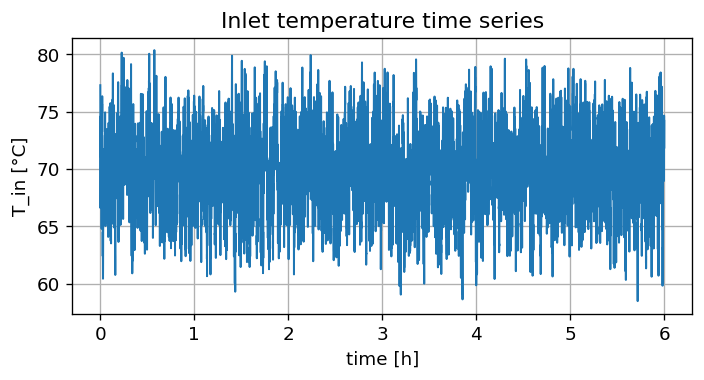

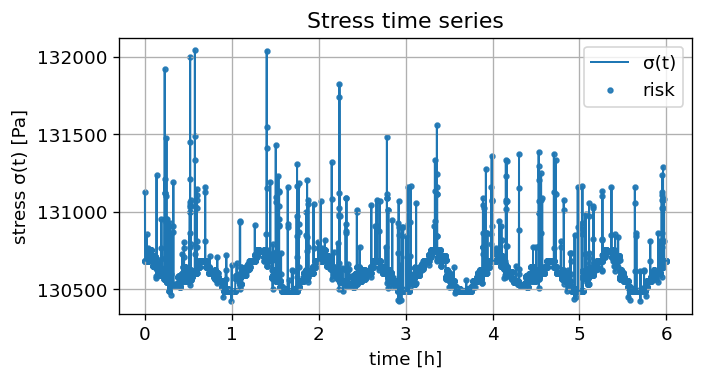

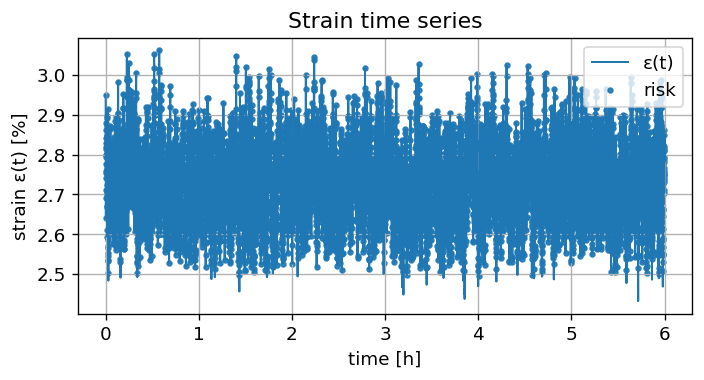

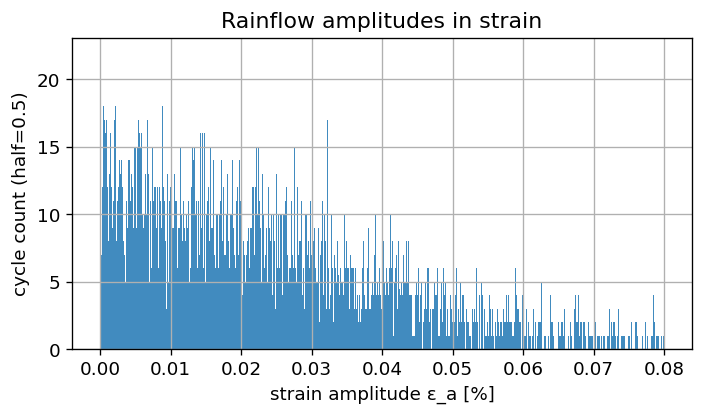

In [17]:
# 15. 변형률 진단(요약/플롯) — 간결판 + 온도 시계열 플롯 추가
import numpy as np
import matplotlib.pyplot as plt

# 15.1 시나리오 생성
DT_S = 2
tN, TinN, constN = scenario_noise(
    total_h=6, dt_s=DT_S,
    Tm=70.0, noise_deg=20.0,    # 변동성 확대
    seed=123, smooth_tau_s=12.0,
    U=1.2, T_amb=25.0, E25=7.5e6, beta=0.01, alpha=2.5e-4, h_o=10.0)

record_hours_N = (len(tN) * DT_S) / 3600.0
t_hours = tN / 3600.0

# 15.2 σ(t) + p_pass(t) + risk 동시 계산
USE_RICH_SCENARIO = True  # True면 U, h_o에 ±5% 동조 변동 부여

def make_xt_fn_basic(t):
    return [constN['U'], float(np.interp(t, tN, TinN)), constN['T_amb'],
            constN['E25'], constN['beta'], constN['alpha'], constN['h_o']]

def make_xt_fn_rich(t):
    return [
        constN['U'] * (1.0 + 0.05*np.sin(2*np.pi*t/3600.0)),   # U ±5%
        float(np.interp(t, tN, TinN)),
        constN['T_amb'], constN['E25'], constN['beta'], constN['alpha'],
        constN['h_o'] * (1.0 + 0.05*np.cos(2*np.pi*t/2400.0)), # h_o ±5%
    ]

make_xt_fn = make_xt_fn_rich if USE_RICH_SCENARIO else make_xt_fn_basic
sigmaN, ppassN, risk_rate, risk_mask = run_scenario_and_risk(make_xt_fn, tN)

# 15.3 변형률 시계열
E_t   = E_of_T(TinN, E25=constN['E25'], beta=constN['beta'])
E_t   = np.maximum(E_t, 1e3)         # 수치 안정 하한
eps_t = sigmaN / E_t                 # [-]
eps_pct = 100.0 * eps_t              # [%]

# 15.4 레인플로우
rf = rainflow(eps_t, eps=0.0)
if rf.size:
    eps_a = rf[:, 0] / 2.0
    w     = rf[:, 2]
    eps_a_pct = 100.0 * eps_a
else:
    eps_a = np.array([], float); w = np.array([], float); eps_a_pct = np.array([], float)

# 15.5 요약
print(f"[RISK] rate = {100*risk_rate:.1f}% (min p_pass = {REG.get('ppass_min', np.nan):.2f}, tau*={REG['tau_star']:.3f})")
print(f"[SIGMA] min={sigmaN.min():.2f} Pa, max={sigmaN.max():.2f} Pa, std={sigmaN.std():.2f} Pa")
print(f"[EPS ] mean={eps_pct.mean():.3f}% ± {eps_pct.std():.3f}%")

# 15.6 플롯 (온도 → 응력 → 변형률 → 레인플로우 히스토그램)
plt.figure(figsize=(6,3.3))
plt.plot(t_hours, TinN, lw=1.2)
plt.xlabel("time [h]"); plt.ylabel("T_in [°C]"); plt.title("Inlet temperature time series")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.3))
plt.plot(t_hours, sigmaN, lw=1.2, label='σ(t)')
if risk_mask.any():
    plt.scatter(t_hours[risk_mask], sigmaN[risk_mask], s=8, label='risk', alpha=0.9)
plt.xlabel("time [h]"); plt.ylabel("stress σ(t) [Pa]"); plt.title("Stress time series")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.3))
plt.plot(t_hours, eps_pct, lw=1.2, label='ε(t)')
if risk_mask.any():
    plt.scatter(t_hours[risk_mask], eps_pct[risk_mask], s=8, label='risk', alpha=0.9)
plt.xlabel("time [h]"); plt.ylabel("strain ε(t) [%]"); plt.title("Strain time series")
plt.legend(); plt.tight_layout(); plt.show()

if eps_a_pct.size:
    xmax = min(0.08, float(eps_a_pct.max()))
    bins = np.linspace(0.0, max(xmax, 1e-5), 1000)
    plt.figure(figsize=(6,3.6))
    plt.hist(eps_a_pct, bins=bins, weights=w, alpha=0.85)
    plt.xlabel("strain amplitude ε_a [%]"); plt.ylabel("cycle count (half=0.5)")
    plt.title("Rainflow amplitudes in strain")
    plt.tight_layout(); plt.show()

###6. Life Prediction

In [18]:
# 16. ε–N 수명 계산
import numpy as np

#16.1 수명 계산함수 - Miner's rule
def compute_life_eN_from_sigma(t, T_in, const, sigma, eps0, b, eps_e=None, rf_eps=0.0):
    """
    ε–N(고무 단순모델): N_f = (eps0 / eps_a)^b, Miner: D = Σ(count / N_f)
    수명[h] = record_hours / D  (D=0 → inf)

    Args:
      t, T_in, sigma : 1D array (time[s], inlet temp[°C], stress[Pa])
      const          : dict(E25, beta) 사용
      eps0, b        : ε–N 파라미터 (무차원)
      eps_e          : 피로 한계 진폭(무차원), 미만은 무손상
      rf_eps         : 레인플로우용 노이즈 컷(변형률 스케일)

    Returns:
      life_hours, D, record_hours, rf_table, eps_t, eps_a, cnt
    """
    t     = np.asarray(t,     float)
    Tin   = np.asarray(T_in,  float)
    sigma = np.asarray(sigma, float)

    if t.size == 0 or sigma.size == 0 or Tin.size != sigma.size:
        return np.inf, 0.0, 0.0, np.zeros((0,3), float), np.array([], float), np.array([], float), np.array([], float)

    #16.1.1 기록 길이(불규칙 샘플링 대응)
    if t.size >= 2:
        dt_est = float(np.median(np.diff(t)))
        record_hours = max(t[-1] - t[0] + dt_est, 0.0) / 3600.0
    else:
        record_hours = 0.0

    #16.1.2 E(T), 변형률
    E25  = float(const.get('E25', 7.5e6))
    beta = float(const.get('beta', 0.01))
    E_t  = np.maximum(E25 * np.exp(-beta * (Tin - 25.0)), 1e3)   # 하한으로 수치안정
    eps_t = sigma / E_t                                          # [-]

    #16.1.3 레인플로우: (range, mean, count)
    rf = rainflow(eps_t, eps=rf_eps)
    if rf.size == 0:
        return np.inf, 0.0, record_hours, rf, eps_t, np.array([], float), np.array([], float)

    eps_a = rf[:, 0] / 2.0
    cnt   = rf[:, 2]

    #16.1.4 피로한계 적용
    msk = (eps_a > 0.0) if eps_e is None else (eps_a >= float(eps_e))
    if not np.any(msk):
        return np.inf, 0.0, record_hours, rf, eps_t, eps_a, cnt

    #16.1.5 Miner 손상
    eps_a_sel = np.maximum(eps_a[msk], 1e-12)
    Nf = (float(eps0) / eps_a_sel) ** float(b)
    D  = float(np.sum(cnt[msk] / np.maximum(Nf, 1e-18)))

    life_hours = (record_hours / D) if D > 0.0 else np.inf
    return life_hours, D, record_hours, rf, eps_t, eps_a, cnt

In [19]:
# 17. ε–N 손상/수명 요약 계산
import numpy as np

#17.1 파라미터
EPS0  = 0.015   # 기준 변형률
B     = 5.0    #  지수
EPS_E = 1e-4   # 피로한계 진폭

#17.2수명/손상 계산
life_hours, D, record_hours, rf_e, eps_t, eps_a, w = compute_life_eN_from_sigma(
    tN, TinN, constN, sigmaN, eps0=EPS0, b=B, eps_e=EPS_E, rf_eps=0.0)

#17.3 리스크(분류기) 메타
risk_rate = REG.get("risk_rate")
ppass_min = REG.get("ppass_min")

#17.4요약 출력
print(f"[σ] min={sigmaN.min():.2f} Pa, max={sigmaN.max():.2f} Pa, std={sigmaN.std():.2f} Pa")
if np.isfinite(life_hours):
    print(f"[ε–N] record={record_hours:.2f} h, D={D:.3e} → life≈{life_hours:.2f} h (~{life_hours/24.0:.2f} d) "
          f"(eps0={EPS0}, b={B}, eps_e={EPS_E})")
else:
    print(f"[ε–N] record={record_hours:.2f} h, D={D:.3e} → life=∞ (eps0={EPS0}, b={B}, eps_e={EPS_E})")
if (risk_rate is not None) and (ppass_min is not None):
    print(f"[RISK] rate={100*risk_rate:.1f}%, min p_pass={ppass_min:.2f}")

#17.5 REG 저장
REG["life_hours"]   = float(life_hours) if np.isfinite(life_hours) else float("inf")
REG["miner_D"]      = float(D)
REG["record_hours"] = float(record_hours)
REG["eps0"]         = float(EPS0)
REG["b"]            = float(B)
REG["eps_e"]        = float(EPS_E)

[σ] min=130422.96 Pa, max=132041.76 Pa, std=105.03 Pa
[ε–N] record=6.00 h, D=4.614e-04 → life≈13003.85 h (~541.83 d) (eps0=0.015, b=5.0, eps_e=0.0001)
[RISK] rate=99.6%, min p_pass=0.01


###7. Risk-Life Scenario Map

In [21]:
# 18. 위험 반영 리포트(수명+리스크 동시 요약) & 완화된 게이팅(덜 보수적)
import numpy as np

#18.1 데이터 요약 및 출력
life_h   = REG["life_hours"]
D        = REG["miner_D"]
rec_h    = REG["record_hours"]
risk_rt  = REG.get("risk_rate", np.nan)
pp_min   = REG.get("ppass_min", np.nan)
tau_star = float(REG["tau_star"])

print(f"[SUMMARY] life={life_h:.2f} h (~{life_h/24:.2f} d), D={D:.3e}, record={rec_h:.2f} h")
print(f"[RISK   ] rate={100*risk_rt:.1f}%  (min p_pass={pp_min:.2f}, tau*={tau_star:.3f})")

#18.2 완화 게이팅 설정: 'quantile'은 하위 q만 제외 / 'floor'는 p_pass < tau_lo만 제외
GATE_MODE = "quantile"     # "quantile" 또는 "floor"
Q_DROP    = 0.10           # 하위 10%만 제외(기본)  ← 덜 보수적
TAU_LO    = 0.5 * tau_star # floor 모드일 때 기준 (예: 0.5·τ*)

#18.3 시나리오 상태 점검 및 보정 함수
def _ensure_scenario():
    #필요 시 p_pass 재계산(15단계와 동일한 make_xt_fn 가정).
    global sigmaN, ppassN, risk_mask
    if 'ppassN' in globals() and 'sigmaN' in globals():
        return sigmaN, ppassN
    # fallback: 15단계의 make_xt_fn이 아직 유효하다고 가정
    def make_xt_fn(t):
        return [constN['U'], float(np.interp(t, tN, TinN)), constN['T_amb'],
                constN['E25'], constN['beta'], constN['alpha'], constN['h_o']]
    _sigma, _pp, *_ = run_scenario_and_risk(make_xt_fn, tN)
    return _sigma, _pp

# 18.4 완화 게이팅 기반 수명 재계산 함수
def recompute_life_relaxed_gating():
    _sigma, _pp = _ensure_scenario()
    if GATE_MODE == "quantile":
        thr = float(np.quantile(_pp, Q_DROP))
        keep = (_pp >= thr)        # 하위 Q_DROP만 제외
        tag  = f"drop bottom {int(100*Q_DROP)}%"
    else:
        keep = (_pp >= TAU_LO)     # p_pass < TAU_LO만 제외(τ*보다 느슨)
        tag  = f"floor p_pass < {TAU_LO:.3f}"

    if keep.sum() < 3:
        return np.inf, 0.0, 0.0, tag

    life2, D2, rec2, *_ = compute_life_eN_from_sigma(
        tN[keep], TinN[keep], constN, _sigma[keep],
        eps0=REG.get("eps0",0.01), b=REG.get("b",4.0),
        eps_e=REG.get("eps_e",1e-4), rf_eps=0.0
    )
    return life2, D2, rec2, tag

# 18.5 실행 및 결과 로깅
life_relax, D_relax, rec_relax, tag = recompute_life_relaxed_gating()
print(f"[RELAX-GATED] ({tag}) life={life_relax:.2f} h (~{life_relax/24:.2f} d), "
      f"D={D_relax:.3e}, record_used={rec_relax:.2f} h")

[SUMMARY] life=13003.85 h (~541.83 d), D=4.614e-04, record=6.00 h
[RISK   ] rate=99.6%  (min p_pass=0.01, tau*=0.107)
[RELAX-GATED] (drop bottom 10%) life=24526.61 h (~1021.94 d), D=2.446e-04, record_used=6.00 h


 Tm  noise    life_h    life_d         D risk_rate ppass_min
 60   10.0 2.888e+05 1.203e+04 2.077e-05     0.266  0.039943
 60   12.5 9.227e+04 3.845e+03 6.503e-05     0.313  0.029905
 60   15.0 8.490e+04 3.538e+03 7.067e-05     0.344  0.022332
 60   17.5 3.880e+04 1.617e+03 1.546e-04     0.366  0.016643
 60   20.0 1.954e+04 8.140e+02 3.071e-04     0.386  0.012385
 65   10.0 2.249e+05 9.372e+03 2.667e-05     0.991  0.022185
 65   12.5 6.742e+04 2.809e+03 8.900e-05     0.965  0.016533
 65   15.0 6.465e+04 2.694e+03 9.281e-05     0.934  0.012303
 65   17.5 2.855e+04 1.189e+03 2.102e-04     0.900  0.009145
 65   20.0 1.443e+04 6.012e+02 4.158e-04     0.868  0.006792
 70   10.0 3.589e+05 1.495e+04 1.672e-05     1.000  0.012222
 70   12.5 1.107e+05 4.611e+03 5.422e-05     1.000  0.009085
 70   15.0 4.584e+04 1.910e+03 1.309e-04     1.000  0.006747
 70   17.5 1.928e+04 8.034e+02 3.112e-04     1.000  0.005008
 70   20.0 8.587e+03 3.578e+02 6.987e-04     0.997  0.003716
 75   10.0 1.790e+05 7.4

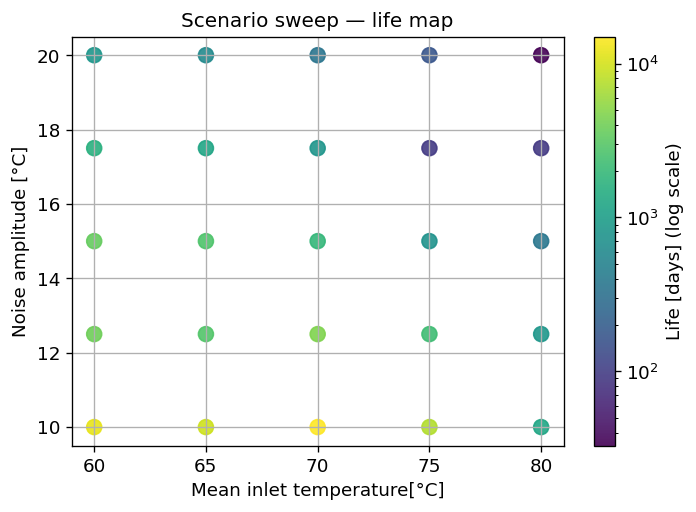

In [23]:
# 19. 시나리오 스윕(온도 레벨 × 노이즈 세기) 지도 — 표 출력 + 소제목/로그컬러 옵션
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#19.1 데이터 설정
Tm_list    = [60, 65, 70, 75, 80]        # 평균 유입온도 [°C]
noise_list = [10, 12.5, 15.0, 17.5, 20.0]  # 노이즈 진폭 [°C]
DT_S       = 2
TOTAL_H    = 6
SEED       = 2025
SMOOTH_TAU = 12.0


#19.2 ε–N 파라미터(기록에 맞춤- 보정 및 수정이 필요한 값)
EPS0  = REG.get("eps0", 0.01)
B     = REG.get("b", 4.0)
EPS_E = REG.get("eps_e", 1e-4)

#19.3 시나리오 스윕
rows = []
for Tm in Tm_list:
    for nz in noise_list:
        tS, TinS, constS = scenario_noise(
            total_h=TOTAL_H, dt_s=DT_S, Tm=Tm, noise_deg=nz,
            seed=SEED, smooth_tau_s=SMOOTH_TAU,
            U=constN['U'], T_amb=constN['T_amb'], E25=constN['E25'],
            beta=constN['beta'], alpha=constN['alpha'], h_o=constN['h_o']
        )
        def mk_xt(t):
            return [constS['U'], float(np.interp(t, tS, TinS)), constS['T_amb'],
                    constS['E25'], constS['beta'], constS['alpha'], constS['h_o']]
        sigS, ppassS, riskS, _ = run_scenario_and_risk(mk_xt, tS)

        lifeH, DM, recH, *_ = compute_life_eN_from_sigma(
            tS, TinS, constS, sigS, eps0=EPS0, b=B, eps_e=EPS_E, rf_eps=0.0
        )

        rows.append(dict(
            Tm=Tm, noise=nz,
            life_h=float(lifeH), life_d=float(lifeH/24.0),
            D=float(DM), risk_rate=float(riskS), ppass_min=float(ppassS.min())
        ))

df_sweep = pd.DataFrame(rows).sort_values(["Tm","noise"]).reset_index(drop=True)
REG["df_sweep"] = df_sweep.copy()

#19.4 표 출력(가독성 포맷)
disp = df_sweep.copy()
disp["life_h"]   = disp["life_h"].map(lambda x: f"{x:.3e}")
disp["life_d"]   = disp["life_d"].map(lambda x: f"{x:.3e}")
disp["D"]        = disp["D"].map(lambda x: f"{x:.3e}")
disp["risk_rate"]= disp["risk_rate"].map(lambda x: f"{x:.3f}")
disp["ppass_min"]= disp["ppass_min"].map(lambda x: f"{x:.6f}")
print(disp.to_string(index=False))

#19.5 산점도 life map 출력
# life가 큰 폭으로 변해 색이 한 톤으로 뭉치면 log 컬러맵이 유리함
cvals = df_sweep["life_d"].clip(lower=1e-6)  # 로그 안정화(하한)
plt.figure(figsize=(6,4.4))
sc = plt.scatter(df_sweep["Tm"], df_sweep["noise"], c=cvals,
                     s=80, alpha=0.9, norm=LogNorm(vmin=cvals.min(), vmax=cvals.max()))
cb_label = "Life [days] (log scale)"

plt.xlabel("Mean inlet temperature[°C]")
plt.ylabel("Noise amplitude [°C]")
cb = plt.colorbar(sc); cb.set_label(cb_label)
plt.title("Scenario sweep — life map", fontsize=12)
plt.tight_layout(); plt.show()